In [ ]:
# default_exp core

# truebranch functions

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%nbdev_export
def say_hello(to):
    "Say hello to somebody"
    return f'Hello {to}!'

In [ ]:
say_hello("Jana")

'Hello Jana!'

In [ ]:
! pip install pytorch-metric-learning==0.9.87.dev4

In [ ]:
! pip install faiss-cpu --no-cache

In [ ]:
%matplotlib inline
import pytorch_metric_learning
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
import pytorch_metric_learning.utils.logging_presets as logging_presets
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from PIL import Image
import logging
import faiss
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
import record_keeper
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s"%pytorch_metric_learning.__version__)

from record_keeper import RecordKeeper, RecordWriter

INFO:root:VERSION 0.9.87.dev4


In [ ]:
#Variables
# Set the image transforms
train_transform = transforms.Compose([transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
train_dataset =  datasets.ImageFolder('/Users/Simona/Documents/Studium/MasterThesisFolder/AdditionalCode/Fresno_Area/train', transform=train_transform)
val_dataset =  datasets.ImageFolder('/Users/Simona/Documents/Studium/MasterThesisFolder/AdditionalCode/Fresno_Area/val', transform=val_transform)
test_dataset =  datasets.ImageFolder('/Users/Simona/Documents/Studium/MasterThesisFolder/AdditionalCode/Fresno_Area/test', transform=val_transform)

## Simple model def

In [ ]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]
        #self.record_these = ["last_linear", "net"]

    def forward(self, x):
        return self.net(x)

## Initialize models, optimizers and image transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.resnet18(pretrained=True)
trunk_output_size = trunk.fc.in_features
trunk.fc = common_functions.Identity()
trunk = torch.nn.DataParallel(trunk.to(device))

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
embedder = torch.nn.DataParallel(MLP([trunk_output_size, 64]).to(device))

# Set optimizers (trying out different learnng rates)
#trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.00001, weight_decay=0.0001)
#embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=0.0001, weight_decay=0.0001)
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.0001, weight_decay=0.0001)
embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=0.001, weight_decay=0.0001)

# Create the loss, miner, sampler, and package them into dictionaries

In [ ]:
# Set the loss function
loss = losses.TripletMarginLoss(margin=0.1)

# Set the mining function
miner = miners.TripletMarginMiner(margin=0.1, type_of_triplets="all")
#miner = miners.MultiSimilarityMiner(epsilon=0.1)

# Set the dataloader sampler
# 4 samples each will be returned -> for us m=2 max
sampler = samplers.MPerClassSampler(train_dataset.targets, m=2, length_before_new_iter=len(train_dataset))
#sampler  = samplers.FixedSetOfTriplets(train_dataset.targets, len(train_dataset))

# Set other training parameters
batch_size = 64
num_epochs = 4

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder}
optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer}
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

In [ ]:
# Remove logs if you want to train with new parameters
!rm -rf example_logs/ example_saved_models/ example_tensorboard/

## Create the training and testing hooks

In [ ]:
! pip install record-keeper tensorboard

In [ ]:
record_keeper, _, _ = logging_presets.get_record_keeper("example_logs", "example_tensorboard")
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"val": val_dataset}
model_folder = "example_saved_models"

In [ ]:
!pip install -q pytorch-metric-learning
!pip install -q faiss-gpu
!pip install -q umap-learn
!pip install -q pynndescent
!pip install -q record-keeper

  ERROR: Command errored out with exit status 1:
   command: /Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/64/cfbgb51x76n53yph6vg0ljhw0000gn/T/pip-install-xgzdbww0/faiss-gpu/setup.py'"'"'; __file__='"'"'/private/var/folders/64/cfbgb51x76n53yph6vg0ljhw0000gn/T/pip-install-xgzdbww0/faiss-gpu/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/64/cfbgb51x76n53yph6vg0ljhw0000gn/T/pip-wheel-qm35cgmg
       cwd: /private/var/folders/64/cfbgb51x76n53yph6vg0ljhw0000gn/T/pip-install-xgzdbww0/faiss-gpu/
  Complete output (8 lines):
  running bdist_wheel
  running build
  running build_ext
  building 'faiss._swigfaiss' extension
  swigging python/swigfaiss.i to python/swigfaiss_wrap.cpp
  swig -python -c++ -Doverride= -I/usr/local/include/fais

In [ ]:
# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(end_of_testing_hook = hooks.end_of_testing_hook, 
                                            dataloader_num_workers = 32)

end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                            dataset_dict, 
                                            model_folder, 
                                            #test_interval = 1,
                                            #patience = 1)
                                           )

In [ ]:
trainer = trainers.MetricLossOnly(models,
                                optimizers,
                                batch_size,
                                loss_funcs,
                                mining_funcs,
                                train_dataset,
                                sampler=sampler,
                                dataloader_num_workers = 32,
                                end_of_iteration_hook = hooks.end_of_iteration_hook,
                                end_of_epoch_hook = end_of_epoch_hook)

In [ ]:
trainer.train(num_epochs=num_epochs)

INFO:root:Initializing dataloader
INFO:root:Initializing dataloader iterator
INFO:root:Done creating dataloader iterator
INFO:root:TRAINING EPOCH 1
  0%|          | 0/36 [00:00<?, ?it/s]/Users/Simona/opt/miniconda3/lib/python3.8/site-packages/pytorch_metric_learning/utils/loss_and_miner_utils.py:120: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  a_idx = triplets.nonzero()[:, 0].flatten()
total_loss=0.07465: 100%|██████████| 36/36 [14:23<00:00, 23.98s/it]
INFO:root:TRAINING EPOCH 2
total_loss=0.09641: 100%|██████████| 36/36 [17:13<00:00, 28.71s/it]  
INFO:root:TRAINING EPOCH 3
total_loss=0.08873: 100%|██████████| 36/36 [14:49<00:00, 24.71s/it]  
INFO:root:TRAINING EPOCH 4
total_loss=0.08846: 100%|██████████| 36/36 [14:42<00:00, 24.51s/it]  


# Saving results

In [ ]:
PATH1 = './SentinelNaip_TripletMarginMiner_trunk.pth'
PATH2 = './SentinelNaip_TripletMarginMiner_embed.pth'
torch.save(trunk.state_dict(), PATH1)
torch.save(embedder.state_dict(), PATH2)

In [ ]:
# Get a dictionary mapping from loss names to lists
loss_histories = hooks.get_loss_history() 

AttributeError: 'EmptyContainer' object has no attribute 'get_loss_history'

In [ ]:
test_dict = {"test": test_dataset}
tester.test(epoch=num_epochs,dataset_dict=test_dict, trunk_model = trunk, embedder_model=embedder)

INFO:root:Evaluating epoch 4
INFO:root:Getting embeddings for the test split
100%|██████████| 6/6 [01:13<00:00, 12.27s/it]
INFO:root:Computing accuracy for the test split
INFO:root:running k-nn with k=2
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=83
INFO:root:embedding dimensionality is 64
INFO:root:defaultdict(<class 'dict'>, {'test': {'epoch': 4, 'AMI_level0': 0.23172787362871838, 'NMI_level0': 0.8651431734890223, 'mean_average_precision_at_r_level0': 0.26506024096385544, 'precision_at_1_level0': 0.26506024096385544, 'r_precision_level0': 0.26506024096385544}})


In [ ]:
# extract embeddings
train_emb, train_lab = tester.get_all_embeddings(train_dataset,trunk_model = trunk, embedder_model=embedder)
val_emb, val_lab = tester.get_all_embeddings(val_dataset, trunk_model = trunk, embedder_model=embedder)
test_emb, test_lab = tester.get_all_embeddings(test_dataset, trunk_model = trunk, embedder_model=embedder)

100%|██████████| 6/6 [01:12<00:00, 12.14s/it]


In [ ]:
'/Users/Simona/Documents/Studium/MasterThesisFolder/AdditionalCode/Fresno_Area/train'
np.savetxt('/Users/Simona/Documents/Studium/MasterThesisFolder/AdditionalCode/Fresno_Area/train_emb_triplet',train_emb)
np.savetxt('/Users/Simona/Documents/Studium/MasterThesisFolder/AdditionalCode/Fresno_Area/train_lab_triplet',train_lab)
np.savetxt('/Users/Simona/Documents/Studium/MasterThesisFolder/AdditionalCode/Fresno_Area/val_emb_triplet',val_emb)
np.savetxt('/Users/Simona/Documents/Studium/MasterThesisFolder/AdditionalCode/Fresno_Area/val_lab_triplet',val_lab)
np.savetxt('/Users/Simona/Documents/Studium/MasterThesisFolder/AdditionalCode/Fresno_Area/test_emb_triplet',test_emb)
np.savetxt('/Users/Simona/Documents/Studium/MasterThesisFolder/AdditionalCode/Fresno_Area/test_lab_triplet',test_lab)

# Distance Plots


In [ ]:
from numpy.linalg import norm
distance_to_ = []
for i in range(0,test_emb.shape[0]):
  sublist = []
  for j in range(0,test_emb.shape[0]):
    labels = tuple([int(test_lab[i]),int(test_lab[j])])
    sublist.append(tuple([norm(test_emb[i]-test_emb[j]),labels]))
    #sublist.sort()
  distance_to_.append(sublist)

# List of distances between Sentinel (anchor) and Naip (pos,neg)

### Plotting anchor, positive and negative distances

In [ ]:
x_neg = []
x_pos = []
x_arr_neg = np.asarray([0]*len(test_dataset))
x_arr_pos = np.asarray([0]*len(test_dataset))
x_arr_neg_list = []
x_arr_pos_list = []
x_arr_labels_list = []
x_arr_labels_list_n = []

for i in range(0,int(len(distance_to_)/2)):
  x_n_ = []
  x_p_ = []
  x_p_labels = []
  x_n_labels = []
  x_n_labels_raw = []
  for j in range(0,int(len(distance_to_)/2)):
    if distance_to_[i*2+1][j*2][1][1] == i:
      x_p_.append(distance_to_[i*2+1][j*2][0]) 
      x_p_labels.append(i)
    else:
      x_n_.append(distance_to_[i*2+1][j*2][0])
      x_n_labels.append((i*2+1,j*2))
      x_n_labels_raw.append((i,j))
  x_arr_neg_ = np.asarray(x_n_)
  x_arr_pos_ = np.asarray(x_p_)
  x_arr_neg_list.append(x_arr_neg_)
  #x_arr_pos = x_arr_pos + x_arr_pos_
  x_arr_pos_list.append(x_arr_pos_)
  x_arr_labels_list.append(x_p_labels)
  x_arr_labels_list_n.append(x_n_labels_raw)
  x_mean_neg = np.mean(x_arr_neg, axis=0)
  x_mean_pos = np.mean(x_arr_pos, axis=0)
  x_std_neg = np.std(x_arr_neg, axis=0)
  x_std_pos = np.std(x_arr_pos, axis=0)

In [ ]:
pip install seaborn

  Using cached seaborn-0.10.1-py3-none-any.whl (215 kB)
  Using cached pandas-1.1.1-cp38-cp38-macosx_10_9_x86_64.whl (10.6 MB)
  Using cached pytz-2020.1-py2.py3-none-any.whl (510 kB)
Note: you may need to restart the kernel to use updated packages.


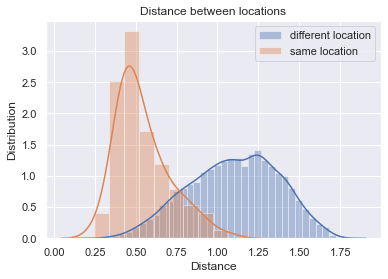

In [ ]:
import seaborn as sns, numpy as np
sns.set()
x = x_arr_neg_list
x_2 =  x_arr_pos_list
ax = sns.distplot(x,label="different location")
ax = sns.distplot(x_2,label="same location")
ax.set(xlabel='Distance', ylabel='Distribution')
plt.title("Distance between locations") 
plt.legend()
plt.show()